## RHO baseline loss plot check

/tmp/ipykernel_3395904/1109131512.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_trai

#### all token counting: 24699544

Dataset: filtered-cured-50k_all_reference -- Token proportion with positive loss diff : 65.31%
Dataset: filtered-cured-50k_all_reference -- selected Token proportion with positive loss diff: 60.0%


/tmp/ipykernel_3395904/1109131512.py:92: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jinlong/LLM_token_selection/venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


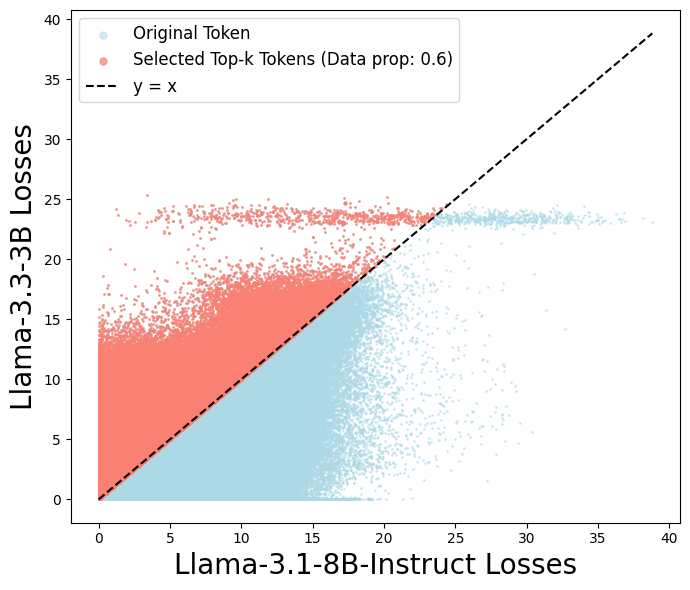

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

def get_global_top_k_indices(data, k):
    flattened = [(value, idx) for idx, value in enumerate(data)]
    top_k = sorted(flattened, key=lambda x: x[0], reverse=True)[:k]  ##loss
    top_k_indices = [item[1] for item in top_k]
    return top_k_indices


def get_half_positive_indices(data):
    selected_flattened = [(value, idx) for idx, value in enumerate(data) if value > 0]
    top_half_positive = sorted(selected_flattened, key=lambda x: x[0], reverse=True)[:int(len(selected_flattened)/2)] ##loss

    top_half_positive_indices = [item[1] for item in top_half_positive]
    return top_half_positive_indices

def get_curve_positive_indices(losses_pre, losses_cur):
    
    alpha = 1.2
    beta = 0.1
    curve_positive_indices=[]
    
    for idx, (sample_losses_pre, sample_losses_cur) in enumerate(zip(losses_pre, losses_cur)):
            if sample_losses_pre > alpha * sample_losses_cur + beta: #linear split
                curve_positive_indices.append(idx)

    return curve_positive_indices

# Data and training parameters
######################################
ref_model_name_or_path="meta-llama/Llama-3.1-8B-Instruct"

# Make sure this is set correctly

dataset_name="filtered-cured-50k_all_reference"

subset_size = 1  # Set to 1 for a single plot

data_prop = 0.6

# Single figure instead of multiple subplots
fig, ax = plt.subplots(figsize=(7, 6))  # Create a single plot (not a grid of subplots)

dataset_name_tag = dataset_name
cur_train_model_name="llama-3.2-3B-base"
cur_train_model_tag = cur_train_model_name 
ref_model_name="reference_model"

losses_cur_train = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{cur_train_model_name}.pt")
losses_ref = torch.load(f"results/loss/token_losses_{dataset_name_tag}_{ref_model_name}.pt")

input_cur_train = [value for sublist in losses_cur_train for value in sublist]
input_ref = [value for sublist in losses_ref for value in sublist]

# 计算两个模型的损失差异
losses_diff = [loss1 - loss2 for loss1, loss2 in zip(input_cur_train, input_ref)]

all_token_count = sum(len(losses) for losses in losses_ref)
print(f"#### all token counting: {all_token_count}\n")

print(f"Dataset: {dataset_name_tag} -- Token proportion with positive loss diff : {round(sum(1 for loss in losses_diff if loss > 0) / len(losses_diff) * 100, 2)}%")

select_global_tokens_indices = get_global_top_k_indices(losses_diff, int(all_token_count * data_prop))
# select_global_tokens_indices = get_half_positive_indices(losses_diff)
# select_global_tokens_indices = get_curve_positive_indices(input_cur_train, input_ref)
print(f"Dataset: {dataset_name_tag} -- selected Token proportion with positive loss diff: {round(len(select_global_tokens_indices) / len(losses_diff) * 100, 2)}%")

# 绘制散点图
ax.scatter(input_ref, input_cur_train, c='lightblue', s=1, alpha=0.5, label="Original Token")

selected_train = [input_cur_train[i] for i in select_global_tokens_indices]
selected_ref = [input_ref[i] for i in select_global_tokens_indices]
ax.scatter(selected_ref, selected_train, c='salmon', s=1, label="Selected Top-k Tokens (Data prop: 0.6)", alpha=0.7)

# 添加标题和标签
# ax.set_title(f"Cur model: {cur_train_model_tag}")
ax.set_xlabel(f"Llama-3.1-8B-Instruct Losses", fontsize=20)
ax.set_ylabel(f"Llama-3.3-3B Losses", fontsize=20)

# 绘制对角线 y = x
min_val = min(min(input_cur_train), min(input_ref))
max_val = max(max(input_cur_train), max(input_ref))
ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='y = x')

# 显示图例
ax.legend(fontsize=12, markerscale=5)

# 调整图形布局
plt.tight_layout()

# 显示图形
plt.show()
